In [1]:
!pip3 install requests_cache
!pip3 install torch
!pip3 install transformers
!pip3 install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import standard libraries
import random
import os
import io
import zipfile
import requests as rq
import requests_cache as rqc
import numpy as np
import pandas as pd
import torch as pt
import transformers as tsf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [3]:
# print environment information
print("ENVIRONMENT INFORMATION")
print("Using numpy version %s" % np.__version__)
print("Using pandas version %s" % pd.__version__)
print("Using pytorch version %s" % pt.__version__)
print("Using transformers version %s" % tsf.__version__)

ENVIRONMENT INFORMATION
Using numpy version 1.22.4
Using pandas version 1.5.3
Using pytorch version 2.0.0+cu118
Using transformers version 4.28.1


In [4]:
# determine available device
device = pt.device("cpu")
if pt.cuda.is_available() :
  device = pt.device("cuda")
  print("Using GPU acceleration")
  ! nvidia-smi
else:
  print("NOT using GPU acceleration")

Using GPU acceleration
Tue Apr 25 12:25:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [5]:
# global configuration
LLM_MODEL_GENERATOR = "gpt2"
LLM_MODEL_SUMMARIZER = "google/pegasus-cnn_dailymail"
TITLE_TEXT_SEPARATOR = "|||"
SUMMARIZATION_MAX_LENGTH = 32
TOKENIZATION_MAX_LENGTH = 1024
TOKENIZATION_TEXT_GENERATION_MAX_LENGTH = 256
MAXIMUM_SUMMARIZATION_SAMPLES_TO_GENERATE = 2

In [6]:
# global initialization - reproducibility
random.seed(10)
np.random.seed(10)
pt.manual_seed(10)

# initialize tqdm for pandas usage
tqdm.pandas()

# disable unimportant warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [7]:
""" Reads the data from a remote zip file """
def get_data_from_remote_zip_file(file_url, file_name):

  response = rqc.CachedSession().get(file_url)
  binary_data = io.BytesIO(response.content)

  raw_data = None

  with zipfile.ZipFile(binary_data) as z:
    with z.open(file_name) as f:
      raw_data = pd.read_csv(f)
      
  return raw_data

In [8]:
# URL and FILE NAME for fake news data
PROCESSED_FAKE_NEWS_URL = "https://github.com/INTERTECHNICA-BUSINESS-SOLUTIONS-SRL/NATO-Article-COVID-Fake-News-Content-Enhancement/raw/main/data/processed/fake_news_data_preprocessed.zip"
PROCESSED_FAKE_NEWS_FILE_NAME = "fake_news_data_preprocessed.csv"

# obtain the fake news dataframe
fake_news_data_frame = get_data_from_remote_zip_file(PROCESSED_FAKE_NEWS_URL, PROCESSED_FAKE_NEWS_FILE_NAME)

In [25]:
# we plan to use the generated text as an input for standard LLM for conditional
# text generation, so we would like to evaluate the length of current fake news
# texts from the perspective of the number of associated tokens
text_generation_tokenizer = tsf.AutoTokenizer.from_pretrained(LLM_MODEL_GENERATOR, use_fast = True)

# create the tokenizer and model used for summarization
text_summarization_tokenizer = tsf.AutoTokenizer.from_pretrained(LLM_MODEL_SUMMARIZER, use_fast = True)
text_summarization_model = tsf.AutoModelForSeq2SeqLM.from_pretrained(LLM_MODEL_SUMMARIZER).to(device)

In [10]:
"""Retrieve the length of a text tokenization sequence"""
def get_tokenization_length(tokenizer, text) :
  tokens = tokenizer(text, max_length = 1024, truncation = True)
  
  return len(tokens["input_ids"])

standard_tokenization_length = lambda text : get_tokenization_length(
    text_generation_tokenizer,
    text
)


In [11]:
# get the distribution for the tokenization length 
tokenization_length_distribution = fake_news_data_frame["text"].apply(standard_tokenization_length)

In [12]:
print("Number of text tokens basic statistics: ")
print(tokenization_length_distribution.describe())

Number of text tokens basic statistics: 
count    1056.000000
mean      601.765152
std       321.243933
min        21.000000
25%       320.750000
50%       586.000000
75%       986.000000
max      1024.000000
Name: text, dtype: float64


In [13]:
print("Number of text tokens series deciles: ")
tokenization_length_distribution.quantile(np.arange(0, 1, 0.1))

Number of text tokens series deciles: 


0.0      21.0
0.1     177.0
0.2     283.0
0.3     358.0
0.4     463.0
0.5     586.0
0.6     690.0
0.7     869.0
0.8    1024.0
0.9    1024.0
Name: text, dtype: float64

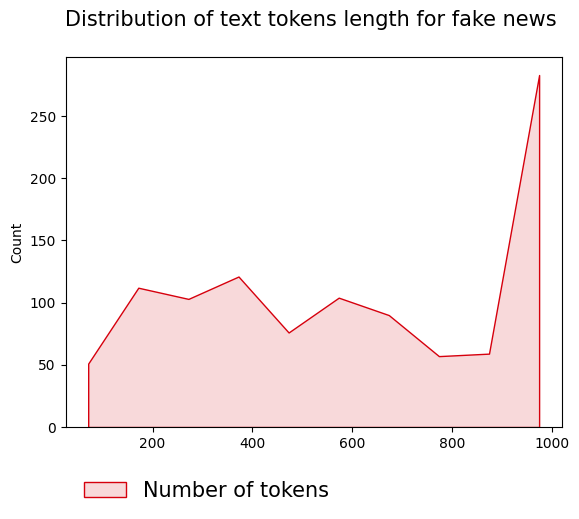

In [14]:
# plot the distribution length
plt.rcParams["patch.force_edgecolor"] = False

plt.rcParams['patch.edgecolor'] = 'none'

sns.histplot(
    tokenization_length_distribution.values, 
    color = "#D6000D", 
    alpha = 0.15, 
    element = "poly", 
    bins = 10
  )

plt.legend(
    ["Number of tokens"],
    loc = 'lower left',
    bbox_to_anchor = (0, -0.25),
    ncol = 1,
    framealpha = 0,
    fontsize = 15
  )

plt.title("Distribution of text tokens length for fake news \n", fontsize = 15)

plt.show()

In [26]:
# calculate the legth needed by the text separator
text_separator_tokenization_length = get_tokenization_length(text_generation_tokenizer, TITLE_TEXT_SEPARATOR)

# from the maximum fake news story tokens we will subtract the 
# tokens needed for fake news story title summarization and the 
# title-text separator string (we will call it the safe length)
# we should generate text covering at least 75% and at most 90% of the safe 
#length (in case we will use another LLM to correct the summarized text) 
text_summarization_safe_length = int(TOKENIZATION_TEXT_GENERATION_MAX_LENGTH - 1.5 * SUMMARIZATION_MAX_LENGTH - text_separator_tokenization_length)
text_summarization_max_length = int(text_summarization_safe_length * 0.9)
text_summarization_min_length = int(text_summarization_safe_length * 0.75)

In [16]:
""" Creates summarized content from a title and text """
def get_summarized_text_samples (
    summarization_tokenizer, 
    summarization_model, 
    text,
    summarization_minimum_length = text_summarization_min_length,
    summarization_maximum_length = text_summarization_max_length,
    device = pt.device("cpu"),
    **kwargs
  ) :

  summary_tokens = summarization_tokenizer(text, return_tensors='pt', truncation=True, max_length = summarization_maximum_length).to(device)
  
  summarized_tokens = summarization_model.generate(
      summary_tokens["input_ids"].to(device),
      min_length = summarization_minimum_length, 
      max_length = summarization_maximum_length,
      **kwargs
    )
  
  generated_samples = summarization_tokenizer.batch_decode(summarized_tokens, skip_special_tokens=True)

  return np.unique(generated_samples)

In [17]:
# create convenience summarization function
get_standard_summarized_text_samples = lambda text : get_summarized_text_samples (
    text_summarization_tokenizer,
    text_summarization_model,
    text,
    num_return_sequences = MAXIMUM_SUMMARIZATION_SAMPLES_TO_GENERATE,   
    device = device,
    do_sample = True,
    top_k= 100, #consider a medium variety of candidates
    top_p = 0.95, #consider a high probability limit for selecting the next token
    temperature = 0.95, #allow a higher degree of variety 
    repetition_penalty = 100000.0, #force diverse results
    num_beams = 3, # use beam search to improve the computation times
    early_stopping = True
)

In [18]:
""" Creates paraphrased titles from fake news dataframe"""
def get_standard_summarized_text_samples_from_dataframe(item) :
  summarized_content_data = get_standard_summarized_text_samples (
      item["text"]
    )
  
  summarized_content_original_index = np.repeat(item["original_index"], summarized_content_data.shape[0])

  summarized_content_dataframe = pd.DataFrame({
      "original_index": summarized_content_original_index,
      "summarized_text": summarized_content_data
  })

  return summarized_content_dataframe

# get paraphrased content from dataframe
summarized_content = fake_news_data_frame.progress_apply(get_standard_summarized_text_samples_from_dataframe, axis = 1)
summarized_samples_dataframe = pd.concat(summarized_content.values, ignore_index = True)

  0%|          | 0/1056 [00:00<?, ?it/s]

In [24]:
# save the processed data
summarized_samples_dataframe.to_csv(
    "./data/processed/summarized_texts.zip",
    compression = {
        "method" : "zip", 
        "archive_name" : "summarized_texts.csv"
    }
  )